In [1]:
#figure out why u=0 does not give rho0 for r=2.3
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from tqdm.auto import trange
from time import time
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import kwant
from numpy import sqrt
import scipy
from itertools import repeat
from numba import njit

import DEDlib

In [1]:
np.linspace(-3,3,1001)[501]


NameError: name 'np' is not defined

In [38]:
"$\\rho$"

'$\\rho$'

In [57]:
sum(np.logspace(2.0, 5, num=50, base=10,dtype='int'))*20/10/60/60/24

17.588773148148146

In [36]:
DOST=np.zeros((16,1001),dtype = 'float')

In [17]:
s.shape

(50,)

In [18]:
b.shape

(50, 1001)

In [24]:
len(np.mean(np.zeros((50,1001)),axis=1))

50

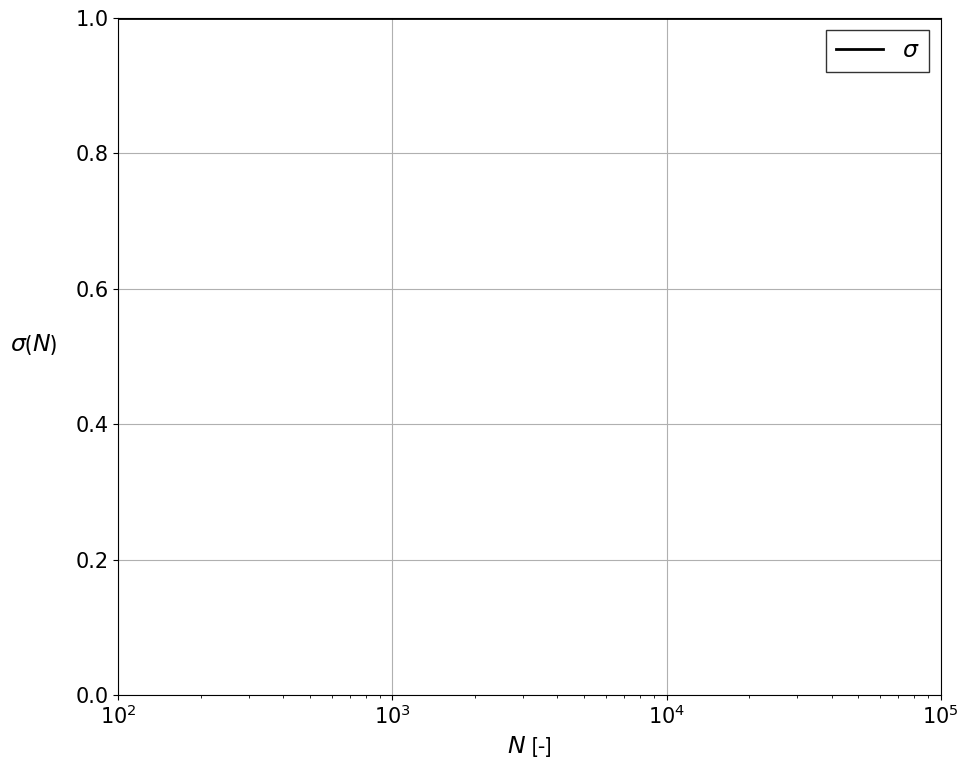

<module 'matplotlib.pyplot' from 'c:\\Users\\roelv\\OneDrive\\Documenten\\VSC\\.conda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [2]:
import DEDlib
DEDlib.stdplot(np.logspace(2.0, 5, num=50, base=10,dtype='int'),np.ones((50,1001)),'g','$\\sigma$')

In [33]:
np.insert(b,0,s, axis=1)

array([[   100.,      0.,      0., ...,      0.,      0.,      0.],
       [   115.,      0.,      0., ...,      0.,      0.,      0.],
       [   132.,      0.,      0., ...,      0.,      0.,      0.],
       ...,
       [ 75431.,      0.,      0., ...,      0.,      0.,      0.],
       [ 86851.,      0.,      0., ...,      0.,      0.,      0.],
       [100000.,      0.,      0., ...,      0.,      0.,      0.]])

In [34]:

np.savetxt('test.txt',np.insert(b,0,s, axis=1),delimiter='\t', newline='\n')

In [26]:
s,b=np.logspace(2, 5, num=50, base=10,dtype='int'),np.zeros((50,1001))
tot=np.append(b,s, axis=0)
tot

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
np.savetxt('test.txt',s,delimiter='\t', newline='\n')

In [48]:
d=np.zeros(5)

for x,d2 in enumerate(d):
    d2=1
    print(d2)
print(d)

1
1
1
1
1
[0. 0. 0. 0. 0.]


In [37]:
std=np.sqrt(np.sum([(dat-np.mean(DOST,axis=0))**2 for dat in DOST],axis=0)/(len(DOST)-1))
stdavg=std/np.sqrt(len(DOST))

In [17]:
data=np.array([[1,4,5,3,2,5,4,3,4,4,4,2,1,1,2,3,4],[3,4,5,3,2,5,4,3,3,4,4,2,5,1,2,4,4],[3,1,1,1,1,1,1,1,1,4,4,3,3,3,1,2,1]])
print(np.std(data,axis=0),np.var(data,axis=0),np.mean(data,axis=0))

[0.94280904 1.41421356 1.88561808 0.94280904 0.47140452 1.88561808
 1.41421356 0.94280904 1.24721913 0.         0.         0.47140452
 1.63299316 0.94280904 0.47140452 0.81649658 1.41421356] [0.88888889 2.         3.55555556 0.88888889 0.22222222 3.55555556
 2.         0.88888889 1.55555556 0.         0.         0.22222222
 2.66666667 0.88888889 0.22222222 0.66666667 2.        ] [2.33333333 3.         3.66666667 2.33333333 1.66666667 3.66666667
 3.         2.33333333 2.66666667 4.         4.         2.33333333
 3.         1.66666667 1.66666667 3.         3.        ]


In [22]:
np.sqrt(np.sum([(dat-np.mean(data,axis=0))**2 for dat in data],axis=0)/(len(data)-1))/np.sqrt(len(data))

array([0.66666667, 1.        , 1.33333333, 0.66666667, 0.33333333,
       1.33333333, 1.        , 0.66666667, 0.8819171 , 0.        ,
       0.        , 0.33333333, 1.15470054, 0.66666667, 0.33333333,
       0.57735027, 1.        ])

In [24]:
x=(1,2)

y=np.zeros((2,2))

y[0]=x

In [25]:
y

array([[1., 2.],
       [0., 0.]])

In [ ]:
N=10000
poles=4
U=3
Sigma=3/2
Ed=-3/2
Gamma=0.3
SizeO=1001
etaco=[0.02,1e-39]
ctype='n'
bound=3
Tk=[0]
posb=1

omega,eta,selectpcT,selectpT= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[]

kb=1
NewM,nonG,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
evals,evecs=scipy.linalg.eigh(H.data.toarray())
Z_tot=np.sum(np.exp(-evals/Tk))
Hexp=np.sum(evals*np.exp(-evals/Tk))/Z_tot
Z_bath=2*np.prod([1+np.exp(ek/Tk) for ek in E_k])
Hbexp=2*np.sum([ek/(1+np.exp(ek/Tk)) for ek in E_k])
S_bath=kb(np.log(np.sum(Z_bath))+Hbexp/Tk)
S_tot=kb(np.log(np.sum(Z_tot))+Hexp/Tk)
S_imp=S_tot-S_bath

In [207]:
def ConstraintS(ctype,H0,H,n,Tk,Nfin=0):
    if ctype[0]=='s':
        vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]
        evals,evecs=scipy.linalg.eigh(H.data.toarray())
        if ctype=='ssn':
            Boltzmann=np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk)*Nfin.astype('int')
            return Boltzmann,evals
        else: return np.exp(-abs(evals[find_nearest(np.diag(np.conj(evecs).T@n.data@evecs),np.conj(vecs)@n.data@vecs.T)]-evals[0])/Tk),evals
    elif ctype[0]=='n':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.sparse.linalg.eigsh(np.real(H0.data), k=1, which='SA')[1][:,0],
                                                scipy.sparse.linalg.eigsh(np.real(H.data), k=1, which='SA')[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='n%2' and int(np.round(exp[0,0]))%2==int(np.round(exp[1,1]))%2: return np.ones(len(Tk)),[]
        elif ctype=='n' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    elif ctype[0]=='d':
        vecs=scipy.sparse.csr_matrix(np.vstack((scipy.linalg.eigh(H.data.toarray(),eigvals=[0, 0])[1][:,0],
                                                scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0])))
        exp=np.conj(vecs)@n.data@vecs.T
        if ctype=='dn' and np.round(exp[0,0])==np.round(exp[1,1]): return np.ones(len(Tk)),[]
        else: return np.zeros(len(Tk)),[]
    else: return np.ones(len(Tk)),[]   

In [208]:
def find_nearest(array,value):
    for i in (i for i,arrval in enumerate(array) if np.isclose(arrval, value, atol=0.1)): return i

In [209]:
def Jordan_wigner_transform(j, lattice_length):
    """Jordan_wigner_transform(j, lattice_length). 
Defines the Jordan Wigner transformation for a 1D lattice."""
    operators = sigmaz()
    for _ in range(j-1): operators = tensor(operators, sigmaz())
    if j == 0: operators = sigmam()
    else: operators = tensor(operators, sigmam())
    for _ in range(lattice_length - j - 1): operators = tensor(operators, identity(2))
    return operators

In [210]:
@njit
def Startrans(poles,select,omega, eta,row=0):
    """Startrans(poles,select,row,omega, eta). 
Function to transform 1D lattice matrices in order to calculates parameters impengergy, bathenergy and Vkk from random sampling distribution."""
    Pbath,Dbath,pbar,G=np.zeros((poles, poles)),np.zeros((poles,poles)),np.zeros((poles, poles)),np.zeros(omega.shape,dtype = 'complex_')
    for i in range(poles-1):
        for j in range(poles-1):
            if j>=i: Pbath[i+1][j+1]=-1/sqrt((poles-i-1)*(poles-i))
        Pbath[i+1][i]=sqrt(poles-i-1)/sqrt(poles-i)
    Pbath[row,:]=1/sqrt(poles)
    for i, _ in enumerate(select): Dbath[i][i]=select[i]
    pbar[1:,1:]=np.linalg.eig(np.dot(Pbath,np.dot(Dbath,Pbath.T))[1:,1:])[1]
    pbar[row][row]=1
    for i, _ in enumerate(select): G+=1 / len(select) / (omega - select[i] + 1.j * eta)
    return np.dot(pbar.T,np.dot(np.dot(Pbath,np.dot(Dbath,Pbath.T)),pbar)),G,select

In [211]:
@njit
def Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2):
    """Lorentzian(omega, Gamma, poles,Ed=-3/2,Sigma=3/2). 
Defines the non-interacting DOS (rho0) and selects random sites based on the number of sites in the 1D lattice model and the calculated distribution."""
    p = np.random.uniform(0, 1, poles)
    return -np.imag(1/(omega-Ed-Sigma+1j*Gamma))/np.pi, np.array([Gamma * np.tan(np.pi * (p[i] - 1 / 2))+Ed+Sigma for i in range(poles)])

In [212]:
def HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma, H0 = 0):
    """HamiltonianAIM(c, impenergy, bathenergy, Vkk, U, Sigma). 
Based on energy parameters calculates the Hamiltonian of a single-impurity system."""
    for i in range(2):
        H0 += impenergy * (c[i].dag() * c[i])
        for j, bathE in enumerate(bathenergy):
            H0 += Vkk[j] * (c[i].dag() * c[2 * j + i + 2] + c[2 * j + i + 2].dag() * c[i])+ bathE * (c[2 * j + i + 2].dag() * c[2 * j + i + 2])
    return H0,H0+U * (c[0].dag() * c[0] * c[1].dag() * c[1])-Sigma * (c[0].dag() * c[0] + c[1].dag() * c[1])

In [297]:
N=10000
poles=4
U=3
Sigma=3/2
Ed=-3/2
Gamma=0.3
SizeO=1001
etaco=[0.02,1e-39]
ctype='n'
bound=3
Tk=np.array([0.000001,0.00001,0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3,1,10,100])
posb=1
omega,eta,selectpcT,selectpT,S_imp,kb,c= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],np.zeros(len(Tk),dtype = 'float'),1,[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
pbar=trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
n,Nfin,i=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros(len(Tk),dtype = 'float'),0

constr=np.zeros(len(Tk),dtype = 'float')
while np.array([con==0 for con in constr]).all():
    NewM,_,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
    E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
    H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
    constr=ConstraintE(ctype,H0,H,n,Tk)
    selectpT.append(select)
selectpcT.append(select)
evals,_=scipy.linalg.eigh(H.data.toarray())

Iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

In [213]:
import time
def Entropyimp(N=10000,poles=4,U=3,Sigma=3/2,Ed=-3/2,Gamma=0.3,SizeO=1001,etaco=[0.02,1e-39],ctype='n',bound=3,Tk=[0],posb=0):
    omega,eta,selectpcT,selectpT,S_imp,S_t,S_b,kb,c= np.linspace(-bound,bound,SizeO),etaco[0]*abs(np.linspace(-bound,bound,SizeO))+etaco[1],[],[],np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),np.zeros(len(Tk),dtype=np.float64),1,[Jordan_wigner_transform(i, 2*poles) for i in range(2*poles)]
    pbar=trange(N,position=posb,leave=False,desc='Iterations',bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    n,Nfin,i=sum([c[i].dag()*c[i] for i in range(2*poles)]),np.zeros(len(Tk),dtype = 'float'),0
    while (np.array([ar<N for _,ar in enumerate(Nfin)]).any() and ctype!='sn') or i<N:
        constr=np.zeros(len(Tk),dtype = 'float')
        while np.array([con==0 for con in constr]).all():
            NewM,_,select=Startrans(poles,np.sort(Lorentzian(omega, Gamma, poles,Ed,Sigma)[1]),omega,eta)
            E_k=[NewM[k+1][k+1] for k in range(len(NewM)-1)]
            H0,H=HamiltonianAIM(c,NewM[0][0],E_k,NewM[0,1:],U,Sigma)
            constr,evals=ConstraintS(ctype,H0,H,n,Tk)
            selectpT.append(select)
        selectpcT.append(select)
        #if ctype==' ':
        #    evals=H.eigenenergies()
        #else:
        if ~np.any(evals):
            evals,_=scipy.linalg.eigh(H.data.toarray())
        Z_tot=scipy.special.logsumexp(np.multiply.outer(-evals,1/Tk,dtype=np.float64),axis=0)


        if (Z_tot>2e+08).any():
            continue
        #Hexp=np.sum(evals[:,None]*np.exp(np.outer(-evals,1/Tk)-Z_tot),axis=0)
        #print(evals[0])
        #Z_tot=-evals[0]/Tk
        #for eval in evals[1:]:
        #    Z_tot=np.logaddexp(Z_tot,-eval/Tk)
        Hexp=np.sum(evals[:,None]*np.exp(np.multiply.outer(-evals,1/Tk,dtype=np.float64)-Z_tot),axis=0)
        
        S_tot=kb*(Z_tot+Hexp/Tk)
        Z_bath=2*sum([np.logaddexp(np.zeros(len(Tk)),-ek/Tk) for ek in E_k])
        H_bath=2*np.sum([ek/np.exp(np.logaddexp(np.zeros(len(Tk)),ek/Tk)) for ek in E_k],axis=0)

        S_bath=kb*(Z_bath+H_bath/Tk)
        S_t+=S_tot*constr
        S_b+=S_bath*constr
        S_imp+=(S_tot-S_bath)*constr
        i+=1
        Nfin+=constr
        #if i>100:
        #    if (0.4>S_t[0:5]/Nfin[0:5]).any() or (0.5<S_t[0:5]/Nfin[0:5]).any():
        #        print(S_t[0:5]/Nfin[0:5],Z_tot[0:5],Hexp[0:5], end='\r')
        #        time.sleep(0.5)
        if ctype=='sn': pbar.n=i
        else: pbar.n=int(min(Nfin))
        pbar.refresh()
    pbar.close()
    return np.abs(S_imp/Nfin).squeeze(),np.real(S_t/Nfin).squeeze(),np.real(S_b/Nfin).squeeze(),Nfin.squeeze(),i

In [195]:
Ni=20000#200000 poles=4
S=Entropyimp(N=2000,poles=6,Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

In [196]:
S4=Entropyimp(N=Ni,poles=4,Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

In [197]:
Sno=Entropyimp(N=Ni,poles=4,ctype=' ',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

In [ ]:
#Sno=Entropyimp(N=2000,poles=6,ctype=' ',Tk=np.logspace(-6,2,801,base=10))

In [198]:
Ssn=Entropyimp(N=Ni,poles=4,ctype='sn',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

C:\Users\roelv\AppData\Local\Temp\ipykernel_25664\1148430448.py:3: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]


In [199]:
Ssn6=Entropyimp(N=2000,poles=6,ctype='sn',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\roelv\AppData\Local\Temp\ipykernel_25664\1148430448.py:3: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]


In [214]:
Ssn6p2=Entropyimp(N=2000,poles=6,ctype='sn',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\roelv\AppData\Local\Temp\ipykernel_25664\3698262583.py:3: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]


In [200]:
Ssn2=Entropyimp(N=Ni,poles=2,ctype='sn',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/20000 [00:00<?, ?it/s]

C:\Users\roelv\AppData\Local\Temp\ipykernel_25664\1148430448.py:3: DeprecationWarning: Keyword argument 'eigvals' is deprecated in favour of 'subset_by_index' keyword instead and will be removed in SciPy 1.12.0.
  vecs=scipy.linalg.eigh(H0.data.toarray(),eigvals=[0, 0])[1][:,0]


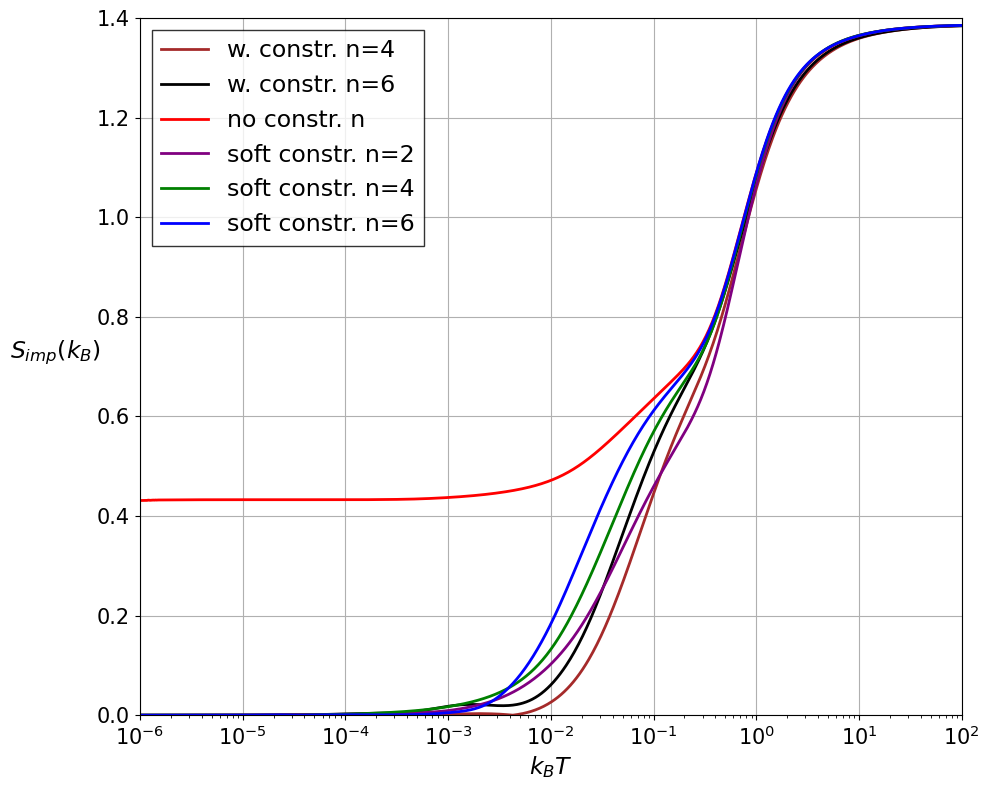

In [201]:
Tk=np.logspace(-6,2,801,base=10)

plt.figure(figsize=(10,8))
plt.rc('legend', fontsize=17)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
axis_font = {'fontname':'Calibri', 'size':'17'}
plt.xlim(min(Tk), max(Tk))
plt.xscale('log')
plt.xlabel("$k_BT$", **axis_font)
plt.gca().set_ylabel("$S_{imp}(k_B)$",va="bottom", rotation=0,labelpad=30,**axis_font)
plt.gca().set_ylim(bottom=0,top=1.4)
plt.plot(Tk,S4[0],'-', color='brown',linewidth=2,label='w. constr. n=4')
plt.plot(Tk,S[0],'-', color='black',linewidth=2,label='w. constr. n=6')
plt.plot(Tk,Sno[0],'-', color='red',linewidth=2,label='no constr. n')
plt.plot(Tk,Ssn2[0],'-', color='purple',linewidth=2,label='soft constr. n=2')
plt.plot(Tk,Ssn[0],'-', color='green',linewidth=2,label='soft constr. n=4')
plt.plot(Tk,Ssn6[0],'-', color='blue',linewidth=2,label='soft constr. n=6')
plt.legend(fancybox=False).get_frame().set_edgecolor('black')
plt.grid()
plt.tight_layout()

In [215]:
Sno6=Entropyimp(N=4000,poles=6,ctype=' ',Tk=np.logspace(-6,2,801,base=10))

Iterations:   0%|          | 0/4000 [00:00<?, ?it/s]

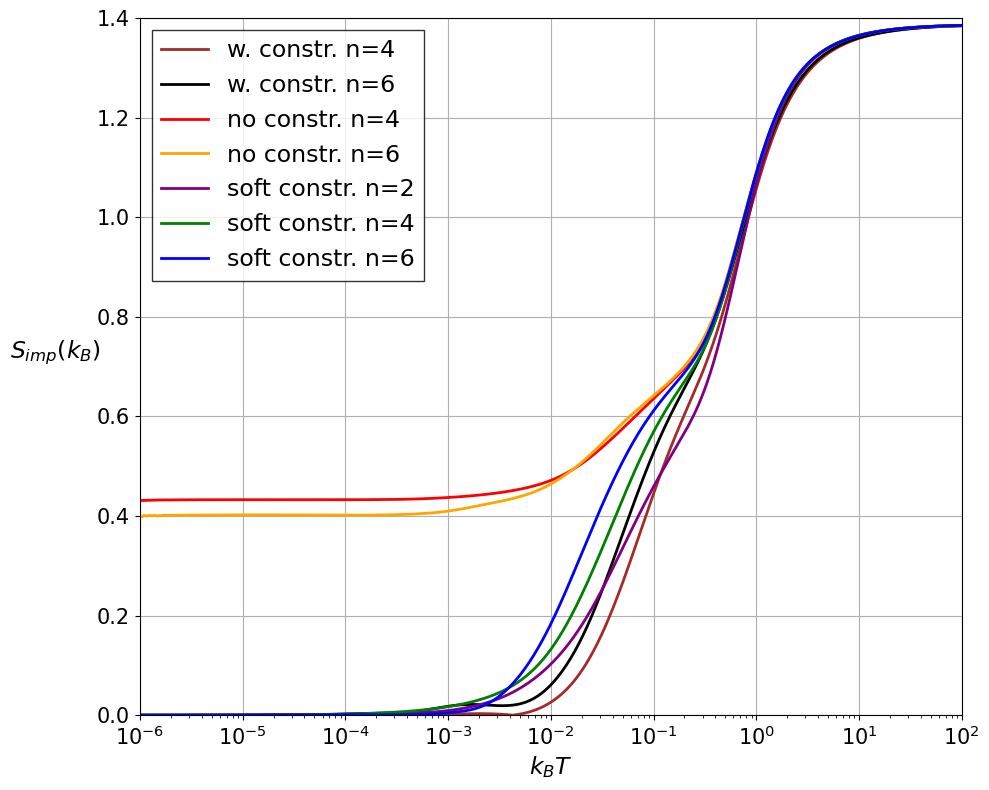

In [ ]:
Tk=np.logspace(-6,2,801,base=10)

plt.figure(figsize=(10,8))
plt.rc('legend', fontsize=17)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
axis_font = {'fontname':'Calibri', 'size':'17'}
plt.xlim(min(Tk), max(Tk))
plt.xscale('log')
plt.xlabel("$k_BT$", **axis_font)
plt.gca().set_ylabel("$S_{imp}(k_B)$",va="bottom", rotation=0,labelpad=30,**axis_font)
plt.gca().set_ylim(bottom=0,top=1.4)
plt.plot(Tk,S4[0],'-', color='brown',linewidth=2,label='w. constr. n=4')
plt.plot(Tk,S[0],'-', color='black',linewidth=2,label='w. constr. n=6')
plt.plot(Tk,Sno[0],'-', color='red',linewidth=2,label='no constr. n=4')
plt.plot(Tk,Sno6[0],'-', color='orange',linewidth=2,label='no constr. n=6')
plt.plot(Tk,Ssn2[0],'-', color='purple',linewidth=2,label='soft constr. n=2')
plt.plot(Tk,Ssn[0],'-', color='green',linewidth=2,label='soft constr. n=4')
plt.plot(Tk,Ssn6[0],'-', color='blue',linewidth=2,label='soft constr. n=6')
plt.legend(fancybox=False).get_frame().set_edgecolor('black')
plt.grid()
plt.tight_layout()

In [ ]:
Ssn6p2

In [ ]:
#test new function constraint

In [ ]:
"""sn takes longer because of constraint linalg.eigh"""

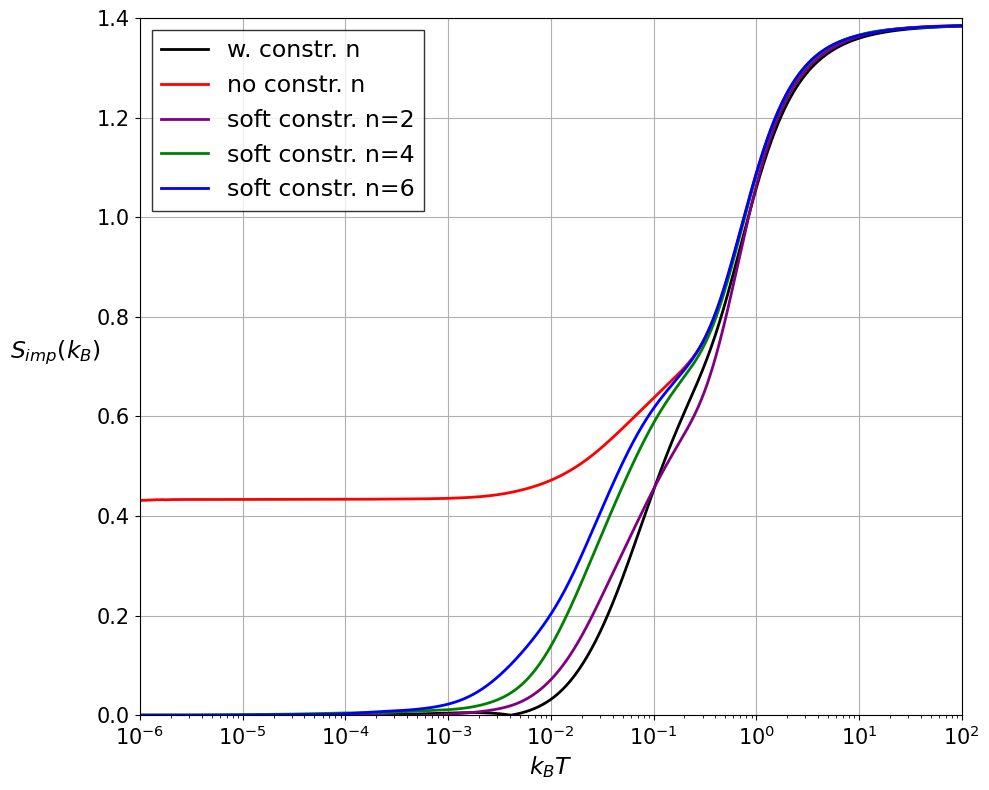

In [188]:
Tk=np.logspace(-6,2,801,base=10)

plt.figure(figsize=(10,8))
plt.rc('legend', fontsize=17)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
axis_font = {'fontname':'Calibri', 'size':'17'}
plt.xlim(min(Tk), max(Tk))
plt.xscale('log')
plt.xlabel("$k_BT$", **axis_font)
plt.gca().set_ylabel("$S_{imp}(k_B)$",va="bottom", rotation=0,labelpad=30,**axis_font)
plt.gca().set_ylim(bottom=0,top=1.4)
plt.plot(Tk,S[0],'-', color='black',linewidth=2,label='w. constr. n')
plt.plot(Tk,Sno[0],'-', color='red',linewidth=2,label='no constr. n')
plt.plot(Tk,Ssn2[0],'-', color='purple',linewidth=2,label='soft constr. n=2')
plt.plot(Tk,Ssn[0],'-', color='green',linewidth=2,label='soft constr. n=4')
plt.plot(np.logspace(-6,2,8001,base=10),Ssn6[0],'-', color='blue',linewidth=2,label='soft constr. n=6')
plt.legend(fancybox=False).get_frame().set_edgecolor('black')
plt.grid()
plt.tight_layout()

In [298]:
Z_tot=scipy.special.logsumexp(np.outer(-evals,1/Tk),axis=0)
Hexp=np.sum(evals[:,None]*np.exp(np.outer(-evals,1/Tk)-Z_tot),axis=0)
S_tot=kb*(Z_tot+Hexp/Tk)
Z_bath=sum([scipy.special.logsumexp([np.zeros(len(Tk)),-ek/Tk],axis=0) for ek in E_k])
H_bath=np.sum([ek/np.exp(scipy.special.logsumexp([np.zeros(len(Tk)),ek/Tk],axis=0)) for ek in E_k],axis=0)
S_bath=kb*(Z_bath+H_bath/Tk)
S_bath,Z_bath,H_bath

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.81898940e-12,
         0.00000000e+00,  0.00000000e+00,  5.51381163e-12,  6.10198429e-04,
         2.07258384e-01,  8.85293690e-01,  1.49292912e+00,  2.06669403e+00,
         2.07931261e+00]),
 array([3.41406245e+06, 3.41406245e+05, 3.41406245e+04, 1.13802082e+04,
        3.41406245e+03, 1.13802082e+03, 3.41406245e+02, 1.13802138e+02,
        3.41933588e+01, 1.17918550e+01, 4.41740227e+00, 2.22795898e+00,
        2.09313770e+00]),
 array([-3.41406245, -3.41406245, -3.41406245, -3.41406245, -3.41406245,
        -3.41406245, -3.41406245, -3.41404585, -3.39861004, -3.27196838,
        -2.92447315, -1.61264955, -1.38250847]))

In [296]:
Z_tot=scipy.special.logsumexp(np.outer(-evals,1/Tk),axis=0)
Hexp=np.sum(evals[:,None]*np.exp(np.outer(-evals,1/Tk)-Z_tot),axis=0)
S_tot=kb*(Z_tot+Hexp/Tk)
Z_bath=sum([scipy.special.logsumexp([np.zeros(len(Tk)),-ek/Tk],axis=0) for ek in E_k])
H_bath=np.sum([ek/np.exp(scipy.special.logsumexp([np.zeros(len(Tk)),ek/Tk],axis=0)) for ek in E_k],axis=0)
S_bath=kb*(Z_bath+H_bath/Tk)
S_bath,Z_bath,H_bath

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.81898940e-12,
        -9.09494702e-13,  2.22751169e-08,  1.44708648e-02,  3.50836270e-01,
         6.47243880e-01,  7.71369975e-01,  1.36507865e+00,  2.06291152e+00,
         2.07927405e+00]),
 array([4.67695408e+06, 4.67695408e+05, 4.67695408e+04, 1.55898469e+04,
        4.67695408e+03, 1.55898469e+03, 4.67697417e+02, 1.56017340e+02,
        4.71996743e+01, 1.62013371e+01, 5.62742991e+00, 2.32686196e+00,
        2.10268336e+00]),
 array([-4.67695408, -4.67695408, -4.67695408, -4.67695408, -4.67695408,
        -4.67695408, -4.67682947, -4.66999511, -4.65524304, -4.62899014,
        -4.26235127, -2.63950443, -2.3409315 ]))

In [264]:
Z_bath=2*np.prod([1+np.exp(-ek/Tk) for ek in E_k],axis=0)

H_bath=2*np.sum([ek/(1+np.exp(ek/Tk)) for ek in E_k],axis=0)
S_bath=kb*(np.log(Z_bath)+H_bath/Tk)
H_bath,S_bath,Z_bath

(array([-1.00034811, -1.00034811, -1.00034811, -1.00034811, -1.00034811,
        -1.00034811, -1.0002472 , -0.98847505, -0.90799131, -0.46663387,
         0.58339238,  2.10314206,  2.29549993]),
 array([          inf,           inf,           inf,           inf,
        -499.48091008, -166.03153857,  -49.31347268,  -15.49863542,
          -2.91975507,    2.04362005,    4.0632871 ,    4.2587023 ,
           4.170307  ]),
 array([            inf,             inf,             inf,             inf,
        3.34089675e+217, 5.11259057e+072, 1.05588040e+022, 3.79026957e+007,
        4.73502885e+002, 3.65640782e+001, 3.24563050e+001, 5.73050122e+001,
        6.32662492e+001]))

In [221]:
Z_bath=sum([scipy.special.logsumexp([np.zeros(len(Tk)),ek/Tk],axis=0) for ek in E_k])+np.log(2)
H_bath=2*np.sum([ek/np.exp(scipy.special.logsumexp([np.zeros(len(Tk)),ek/Tk],axis=0)) for ek in E_k],axis=0)
S_bath=kb*(Z_bath+H_bath/Tk)
S_bath

array([-6.43469029e+05, -3.21665546e+03, -3.21041714e+02, -3.14803355e+01,
       -9.97660198e+00, -1.80518649e+00])

In [262]:
S_imp=(S_tot-S_bath)
S_imp

array([5.00173364e+05, 5.00167126e+04, 5.00104743e+03, 1.66655371e+03,
       4.99546890e+02, 1.66783251e+02, 5.03792212e+01, 1.67389894e+01,
       5.37458368e+00, 2.88515021e+00, 3.13252293e+00, 4.04116944e+00,
       4.14727843e+00])

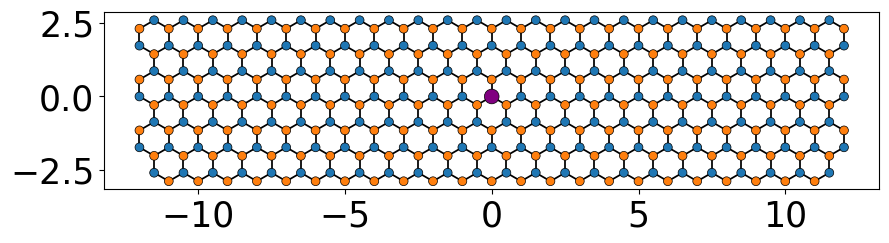

In [2]:
imp,func,args,colorbnd,structname,nd=85,DEDlib.GrapheneNRarmchairstruct,(3,12,-2.8867513459481287),171,'armchair',np.zeros((2,4,2),dtype = 'float')


psi,SPG,eig,SPrho0=DEDlib.GrapheneAnalyzer(imp,func(*args),colorbnd,'GrapheneNR'+structname+str(imp)+'pos')        

In [9]:
nd[1]

array([1.00152831, 1.00165914, 1.00170411, 1.00315413, 1.00228651,
       1.00382232])

Iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

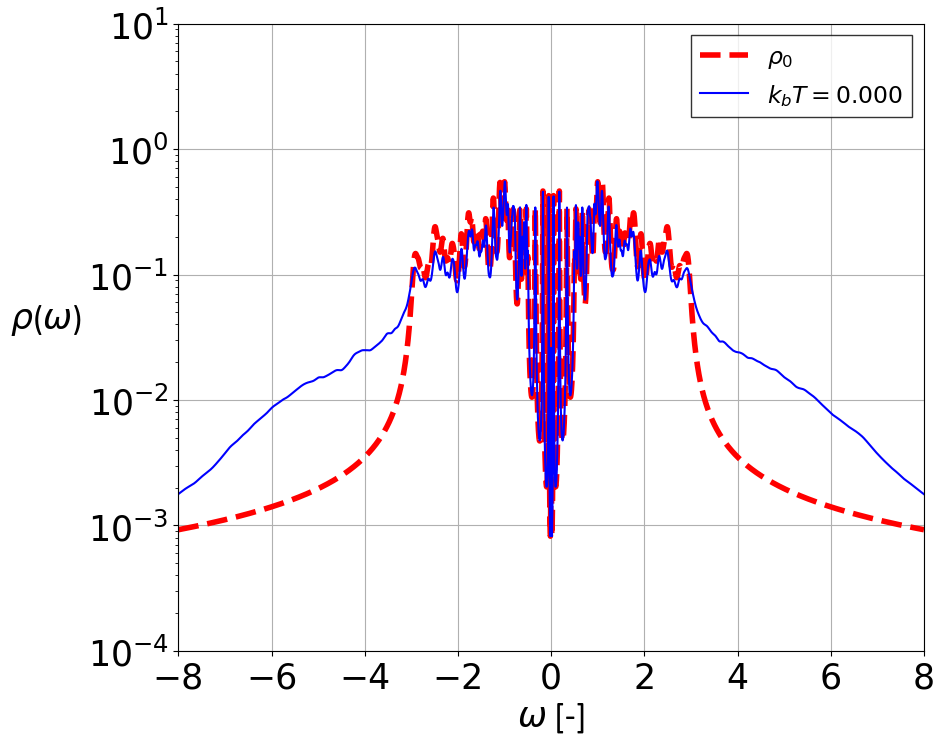

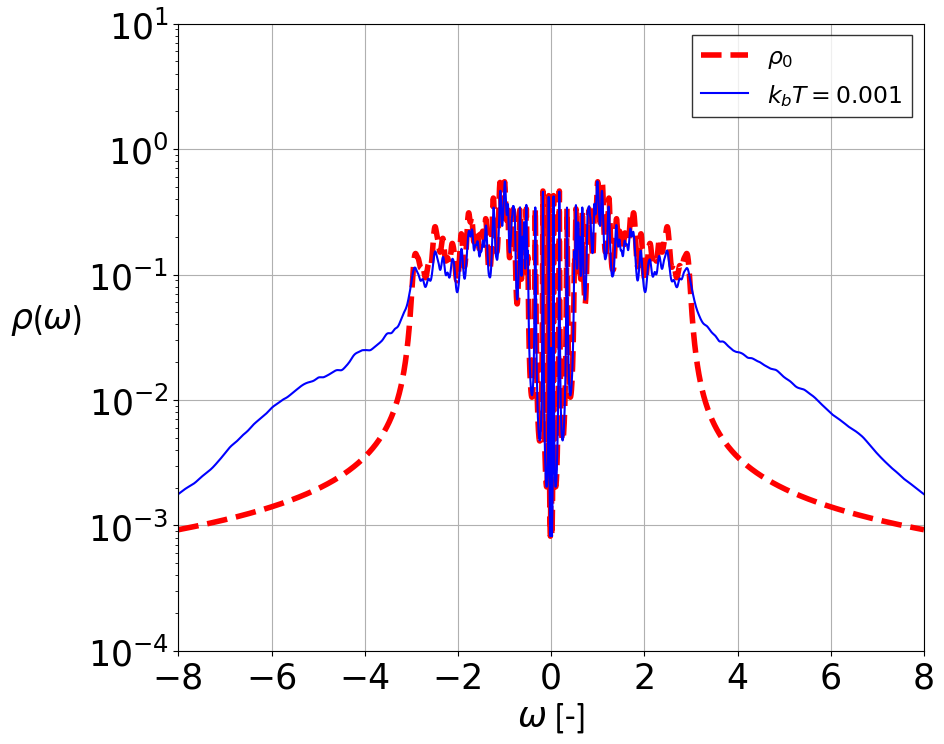

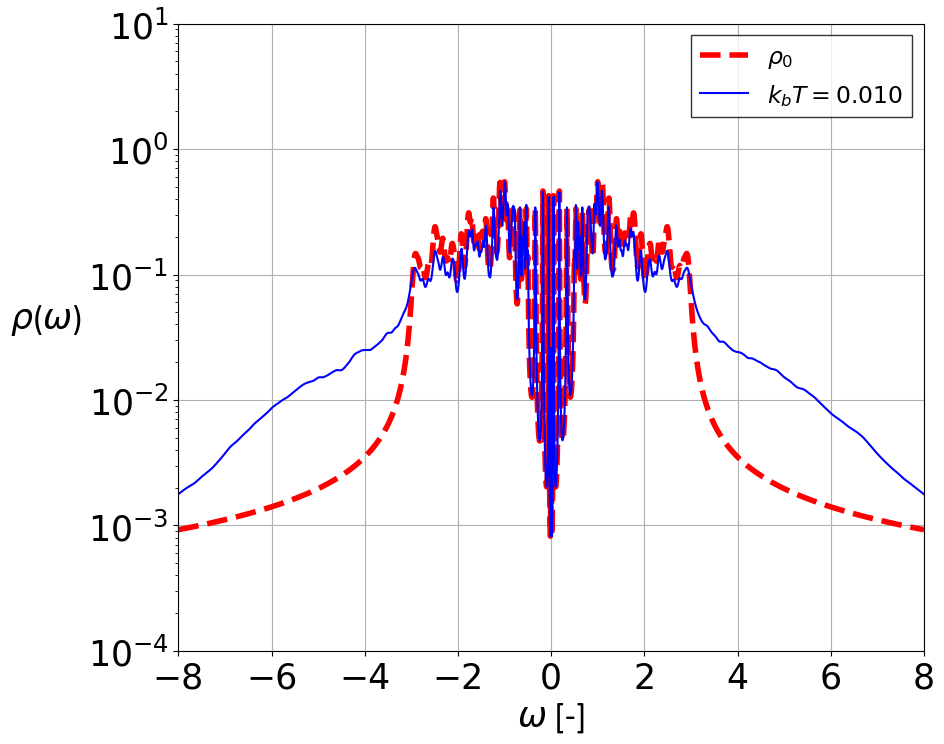

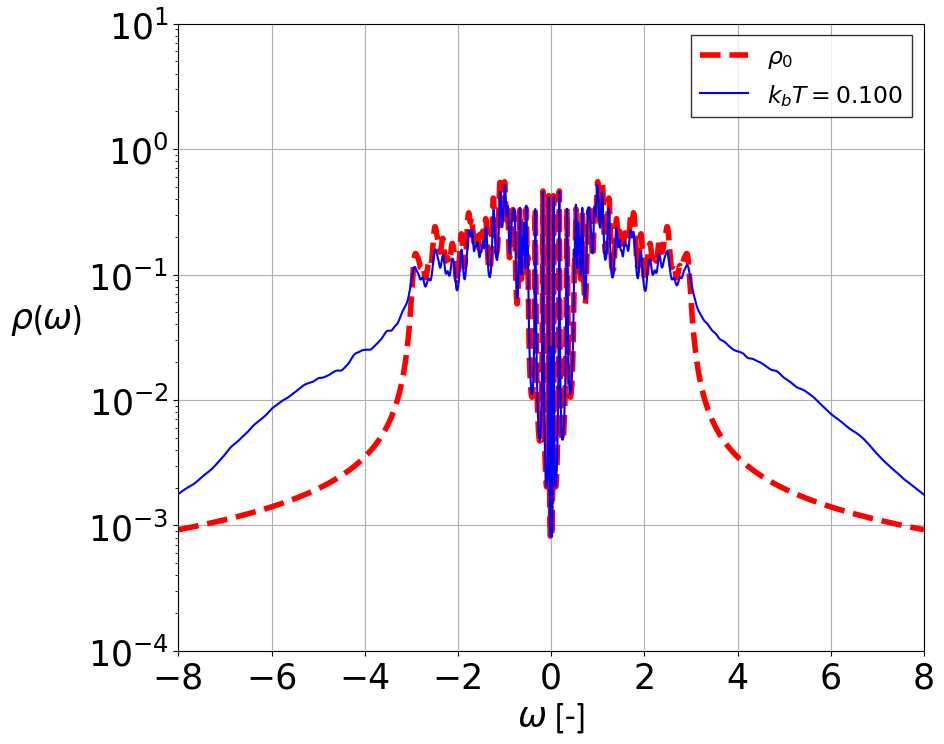

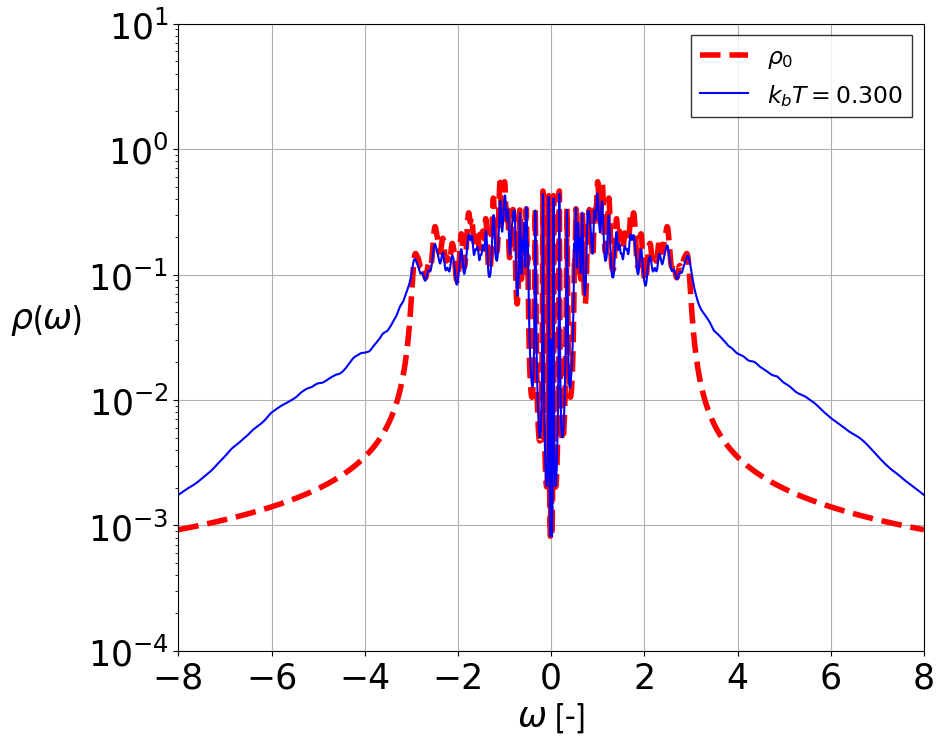

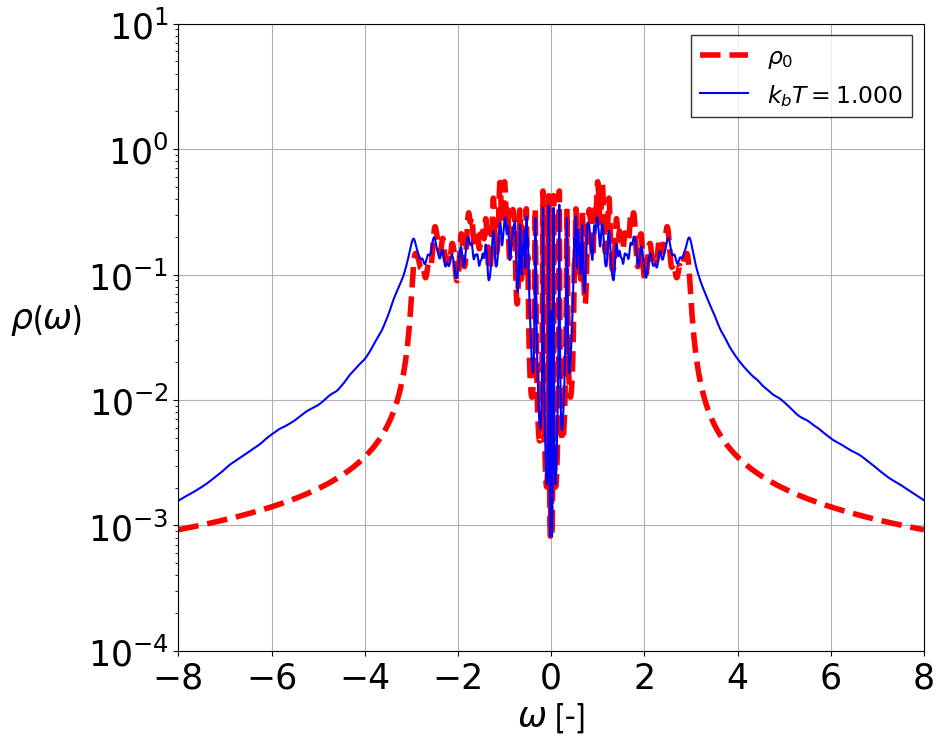

In [3]:
inp={"N" : 2000, "poles" : 4, "U" : 3, "Sigma" : 1.5, "Ed" : -3/2, "ctype" : 'ssn', "bound" : 8, "eigsel" : False,"Tk" : [0.000000000001,0.001,0.01,0.1,0.3,1]}
labelnames=['$\it{k_bT= %.3f}$'%0.000,'$\it{k_bT= %.3f}$'%0.001,'$\it{k_bT= %.3f}$'%0.010,'$\it{k_bT= %.3f}$'%0.100,'$\it{k_bT= %.3f}$'%0.300,'$\it{k_bT= %.3f}$'%1.000]
filenames=['cN4pT1e-12','cN4pT1e-3','cN4pT1e-2','cN4pT1e-1','cN4pT3e-1','cN4pT1']
nd, AvgSigmadat, DOST, nonintrho, omega, selectpT, selectpcT=DEDlib.Graphene_main(psi,SPG,eig,SPrho0,**inp,posb=4)
for i,file in enumerate(filenames):
    DEDlib.DOSplot(DOST[i], nonintrho, omega,file,labelnames[i],log=True)